In [1]:
from keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()


C:\Users\Alekh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

#### Preparing Data

In [6]:
mean=train_data.mean(axis=0)
train_data-=mean

std=train_data.std(axis=0)
train_data/=std

test_data-=mean
test_data/=std

#### Building network

In [9]:
from keras import models
from keras import layers

def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

#### K fold Validation

In [13]:
import numpy as np

k=4
num_val_samples=len(train_data)//k
num_epochs=100
all_scores=[]


for i in range(k):
    print('processing fold #', i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0)
    
    partial_train_targets=np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    model=build_model()
    model.fit(partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=1,verbose=0)
    val_mse,val_mae=model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
print(all_scores)
print('mean mae',format(np.mean(all_scores)))


[2.0307204416482754, 2.4033245096112243, 2.4738134275568595, 2.7375497463906164]
mean mae 2.411352031301744


#### Saving the validation logs at each fold

In [24]:
import numpy as np

k=4
num_val_samples=len(train_data)//k
num_epochs=500
all_mae_histories=[]


for i in range(k):
    print('processing fold #', i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0)
    
    partial_train_targets=np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    model=build_model()
    history=model.fit(partial_train_data,partial_train_targets,validation_data=(val_data,val_targets),epochs=num_epochs,batch_size=1,verbose=0)
    mae_history=history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [25]:
average_mae_history=[
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [47]:
np.array(average_mae_history).shape

(500,)

#### Plotting Validation Scores

In [49]:
% matplotlib inline

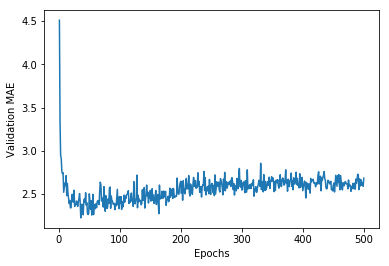

In [50]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [73]:
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            
            previous=smoothed_points[-1]
            print(previous*factor)
            
            smoothed_points.append(previous*factor + point *(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [75]:
smooth_mae_history=smooth_curve(average_mae_history[10:])

2.337198314454296
2.347548734268339
2.3359621158259927
2.3383080645122147
2.330247064158043
2.317610279370624
2.3009333100700475
2.2889910272842533
2.270688339348484
2.254210145967969
2.2479609956258115
2.2478004851978057
2.2401280351645383
2.232587996406865
2.2381911665463927
2.2263479164951328
2.217247417984954
2.2094628804975844
2.2062157158563607
2.200998401301495
2.192960597218233
2.190222857818069
2.1912705730766167
2.197580850108172
2.1953259049638154
2.1758586825862865
2.1676992256471452
2.165283608810078
2.161332478115816
2.148497162416805
2.1514859620209807
2.1563146873492154
2.156718983008714
2.1672593208101074
2.163755219814755
2.163181994575634
2.151393480254186
2.1398166834344683
2.1304979769092256
2.1425997848951996
2.146352374353086
2.1408755521102023
2.1447561807140714
2.1333049248385008
2.1263521107442473
2.1383950263024
2.1280365392292695
2.1292527165955017
2.1290426798222533
2.1258780690555805
2.1281906759370335
2.126249376239038
2.1307045055273797
2.135716598621577

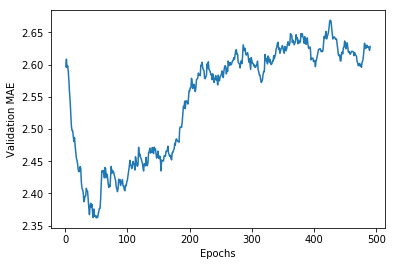

In [76]:
plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [77]:
model=build_model()
model.fit(train_data,train_targets,
         epochs=80,batch_size=16,verbose=0)

In [78]:
test_mse_score,test_mae_score=model.evaluate(test_data,test_targets)

102/102 [==============================] - 0s 2ms/step


In [79]:
test_mae_score

2.5889533641291598